# Chapter 3 Group Lasso

In [2]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

C:\Users\prof-\anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 3.1 When One Group Exists

In [1]:
def gr(X, y, lam):
    p = X.shape[1]
    nu = 1 / np.max(np.linalg.eigvals(X.T @ X))
    beta = np.zeros(p)
    beta_old = np.zeros(p)
    eps = 1
    while eps > 0.001:
        gamma = beta + nu * X.T @ (y - X @ beta)
        beta = max(1 - lam * nu / np.linalg.norm(gamma, 2), 0) * gamma
        eps = np.max(np.abs(beta - beta_old))
        beta_old = copy.copy(beta)
    return beta

In [3]:
n = 100
p = 3
X = randn(n, p)
beta = randn(p)
epsilon = randn(n)
y = 0.1 * X @ beta + epsilon
lambda_seq = np.arange(1, 50, 0.5)
m = len(lambda_seq)
beta_est = np.zeros((m, p))
for i in range(m):
    est = gr(X, y, lambda_seq[i])
    beta_est[i, :] = est

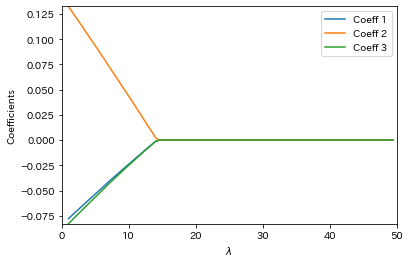

In [4]:
plt.xlim(0, 50)
plt.ylim(np.min(beta_est), np.max(beta_est))
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
labels = ["Coeff 1", "Coeff 2", "Coeff 3"]
for i in range(p):
    plt.plot(lambda_seq, beta_est[:, i], label="{}".format(labels[i]))
plt.legend(loc="upper right")
plt.show()

## 3.2 Proximal Gradient Method

In [5]:
def fista(X, y, lam):
    p = X.shape[1]
    nu = 1 / np.max(np.linalg.eigvals(X.T @ X))
    alpha = 1
    beta = np.zeros(p)
    beta_old = np.zeros(p)
    gamma = np.zeros(p)
    eps = 1
    while eps > 0.001:
        w = gamma + nu * X.T @ (y - X @ gamma)
        beta = max(1 - lam * nu / np.linalg.norm(w, 2), 0) * w
        alpha_old = copy.copy(alpha)
        alpha = (1 + np.sqrt(1 + 4 * alpha**2)) / 2
        gamma = beta + (alpha_old - 1) / alpha * (beta - beta_old)
        eps = np.max(np.abs(beta - beta_old))
        beta_old = copy.copy(beta)
    return beta

## 3.3 Group Lasso

In [6]:
def group_lasso(z, y, lam=0):
    J = len(z)
    theta = []
    for i in range(J):
        theta.append(np.zeros(z[i].shape[1]))
    for m in range(10):
        for j in range(J):
            r = copy.copy(y)
            for k in range(J):
                if k != j:
                    r = r - z[k] @ theta[k]
            theta[j] = gr(z[j], r, lam)
    return theta

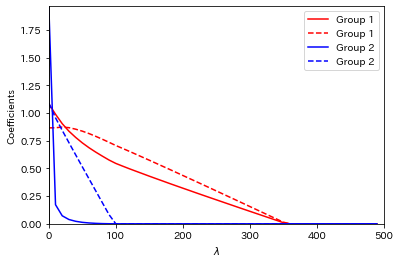

In [7]:
n = 100
J = 2
u = randn(n)
v = u + randn(n)
s = 0.1 * randn(n)
t = 0.1 * s + randn(n)
y = u + v + s + t + randn(n)
z = []
z = np.array([np.array([u, v]).T, np.array([s, t]).T])
lambda_seq = np.arange(0, 500, 10)
m = len(lambda_seq)
beta = np.zeros((m, 4))
for i in range(m):
    est = group_lasso(z, y, lambda_seq[i])
    beta[i, :] = np.array([est[0][0], est[0][1], est[1][0], est[1][1]])
plt.xlim(0, 500)
plt.ylim(np.min(beta), np.max(beta))
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
labels = ["Group 1", "Group 1", "Group 2", "Group 2"]
cols = ["red", "blue"]
lins = ["solid", "dashed"]
for i in range(4):
    plt.plot(lambda_seq, beta[:, i], color=cols[i//2],
             linestyle=lins[i % 2], label="{}".format(labels[i]))
plt.legend(loc="upper right")
plt.axvline(0, color="black")

## 3.4 Sparse Group Lasso 

In [17]:
## From Chapter 1
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)
def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Mean of each column of X
    X_sd = np.zeros(p)                    # SD of each column of X
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Centralize each column of X
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Centralize each column of X
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # Mean of y
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # Centralize y
    else:                                 # when y is a vector
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

In [18]:
def sparse_gr(X, y, lam, alpha):
    p = X.shape[1]
    nu = 1 / np.max(np.linalg.eigvals(X.T @ X))
    beta = np.zeros(p)
    beta_old = np.zeros(p)
    eps = 1
    while eps > 0.001:
        gamma = beta + nu * X.T @ (y - X @ beta)
        delta = soft_th(lam * alpha, gamma)                                             ##
        beta = np.zeros(p)
        if np.linalg.norm(delta, 2) > 0:
            beta = max(1 - lam * nu * (1-alpha) / np.linalg.norm(delta, 2), 0) * delta  ##
        eps = np.max(np.abs(beta - beta_old))
        beta_old = copy.copy(beta)
    return beta

In [19]:
def sparse_group_lasso(z, y, lam=0, alpha=0):
    J = len(z)
    theta = []
    for i in range(J):
        theta.append(np.zeros(z[i].shape[1]))
    for m in range(10):
        for j in range(J):
            r = copy.copy(y)
            for k in range(J):
                if k != j:
                    r = r - z[k] @ theta[k]
                theta[j] = sparse_gr(z[j], r, lam, alpha)                               ##
    return theta

## 3.5 Overlap Lasso

## 3.6 Group Lasso with Multiple Responses 

In [20]:
def gr_multi_linear_lasso(X, Y, lam):
    n, p = X.shape
    K = Y.shape[1]
    X, Y, x_bar, x_sd, y_bar = centralize(X, Y)
    beta = np.zeros((p, K))
    gamma = np.zeros((p, K))
    eps = 1
    while eps > 0.01:
        gamma = copy.copy(beta)
        R = Y - X @ beta
        for j in range(p):
            r = R + X[:, j].reshape(n, 1) @ beta[j, :].reshape(1, K)
            M = X[:, j] @ r
            beta[j, :] = (max(1 - lam / np.sqrt(np.sum(M*M)), 0)
                          / np.sum(X[:, j] * X[:, j]) * M)
            R = r - X[:, j].reshape(n, 1) @ beta[j, :].reshape(1, K)
        eps = np.linalg.norm(beta - gamma)
    for j in range(p):
        beta[j, :] = beta[j, :] / x_sd[j]
    beta_0 = y_bar - x_bar @ beta
    return [beta_0, beta]

In [21]:
df = np.loadtxt("giants_2019.txt", delimiter="\t")
index = list(set(range(9)) - {1, 2})
X = np.array(df[:, index])
Y = np.array(df[:, [1, 2]])
lambda_seq = np.arange(0, 200, 5)
m = len(lambda_seq)
beta_1 = np.zeros((m, 7))
beta_2 = np.zeros((m, 7))

In [22]:
for i in range(m):
    beta = gr_multi_linear_lasso(X, Y, lambda_seq[i])
    beta_1[i, :] = beta[1][:, 0]
    beta_2[i, :] = beta[1][:, 1]
beta_max = np.max(np.array([beta_1, beta_2]))
beta_min = np.min(np.array([beta_1, beta_2]))

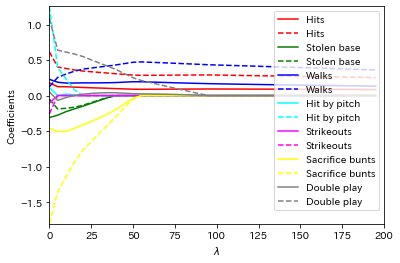

In [23]:
plt.xlim(0, 200)
plt.ylim(beta_min, beta_max)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
labels = ["Hits", "Stolen base", "Walks", "Hit by pitch", "Strikeouts", "Sacrifice bunts", "Double play"]
cols = ["red", "green", "blue", "cyan", "magenta", "yellow", "gray"]
lins = ["solid", "dashed"]
for i in range(7):
    plt.plot(lambda_seq, beta_1[:, i], color=cols[i], linestyle=lins[0],
             label="{}".format(labels[i]))
    plt.plot(lambda_seq, beta_2[:, i], color=cols[i], linestyle=lins[1],
             label="{}".format(labels[i]))
plt.legend(loc="upper right")

## 3.7 Group Lasso via Logistic Regression 

In [24]:
def gr_multi_lasso(X, y, lam):
    n = X.shape[0]
    p = X.shape[1]
    K = len(np.unique(y))
    beta = np.ones((p, K))
    Y = np.zeros((n, K))
    for i in range(n):
        Y[i, y[i]] = 1
    eps = 1
    while eps > 0.001:
        gamma = copy.copy(beta)
        eta = X @ beta
        P = np.exp(eta)
        for i in range(n):
            P[i, ] = P[i, ] / np.sum(P[i, ])
        t = 2 * np.max(P*(1-P))
        R = (Y-P) / t
        for j in range(p):
            r = R + X[:, j].reshape(n, 1) @ beta[j, :].reshape(1, K)
            M = X[:, j] @ r
            beta[j, :] = (max(1 - lam / t / np.sqrt(np.sum(M*M)), 0)
                          / np.sum(X[:, j]*X[:, j]) * M)
            R = r - X[:, j].reshape(n, 1) @ beta[j, :].reshape(1, K)
        eps = np.linalg.norm(beta - gamma)
    return beta

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"])

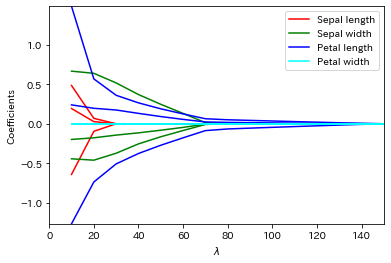

In [26]:
lambda_seq = np.arange(10, 151, 10)
m = len(lambda_seq)
p = X.shape[1]
K = 3
alpha = np.zeros((m, p, K))
for i in range(m):
    res = gr_multi_lasso(X, y, lambda_seq[i])
    alpha[i, :, :] = res
plt.xlim(0, 150)
plt.ylim(np.min(alpha), np.max(alpha))
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
handles = []
labels = ["Sepal length", "Sepal width", "Petal length", "Petal width"]
cols = ["red", "green", "blue", "cyan"]
for i in range(4):
    for k in range(K):
        line, = plt.plot(lambda_seq, alpha[:, i, k], color=cols[i], label="{}".format(labels[i]))
    handles.append(line)
plt.legend(handles, labels, loc="upper right")

## 3.8 Group Lasso for the Generalized Additive Models

In [27]:
n = 100
J = 2
x = randn(n)
y = x + np.cos(x)
z = [np.array([np.ones(n), x]).T, np.array([np.cos(x), np.cos(2*x), np.cos(3*x)]).T]
lambda_seq = np.arange(1, 200, 5)
m = len(lambda_seq)
beta = np.zeros((m, 5))
for i in range(m):
    est = group_lasso(z, y, lambda_seq[i])
    beta[i, :] = np.array([est[0][0], est[0][1], est[1][0], est[1][1], est[1][2]])

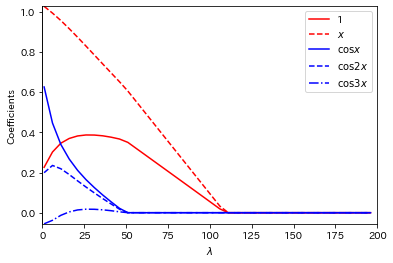

In [28]:
plt.xlim(0, 200)
plt.ylim(np.min(beta), np.max(beta))
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficients")
labels = ["1", "$x$", r"$\cos x$", r"$\cos 2x$", r"$\cos 3x$"]
cols = ["red", "blue"]
lins = ["solid", "dashed", "dashdot"]
plt.plot(lambda_seq, beta[:, 0], color=cols[0], linestyle=lins[0],
         label="{}".format(labels[0]))
plt.plot(lambda_seq, beta[:, 1], color=cols[0], linestyle=lins[1],
         label="{}".format(labels[1]))
plt.plot(lambda_seq, beta[:, 2], color=cols[1], linestyle=lins[0],
         label="{}".format(labels[2]))
plt.plot(lambda_seq, beta[:, 3], color=cols[1], linestyle=lins[1],
         label="{}".format(labels[3]))
plt.plot(lambda_seq, beta[:, 4], color=cols[1], linestyle=lins[2],
         label="{}".format(labels[4]))
plt.legend(loc="upper right")
plt.axvline(0, color="black")

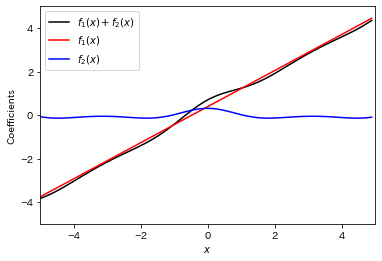

In [29]:
i = 5
def f_1(x):
    return beta[i, 0] + beta[i, 1] * x
def f_2(x):
    return beta[i, 2] * np.cos(x) + beta[i, 3] * np.cos(2*x) + beta[i, 4] * np.cos(3*x)
def f(x):
    return f_1(x) + f_2(x)
x_seq = np.arange(-5, 5, 0.1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("Coefficients")
labels = ["$f_1(x) + f_2(x)$", "$f_1(x)$", "$f_2(x)$"]
cols = ["black", "red", "blue"]
plt.plot(x_seq, f(x_seq), color=cols[0], label="{}".format(labels[0]))
plt.plot(x_seq, f_1(x_seq), color=cols[1], label="{}".format(labels[1]))
plt.plot(x_seq, f_2(x_seq), color=cols[2], label="{}".format(labels[2]))
plt.legend()